<a href="https://colab.research.google.com/github/ValentineFil/-Projects_in_Pytorch/blob/main/%5BDone%5D_A_Dive_into_Natural_Language_Processing_Lesson_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Dive into Natural Language Processing.

Сегодня мы дообучим модель mT5, на задачу машинного перевода с русского на английский и обратно.



In [ ]:
!nvidia-smi

Fri Nov 26 10:40:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

In [ ]:
!pip install transformers sentencepiece datasets translate-toolkit --quiet

     |████████████████████████████████| 3.1 MB 15.0 MB/s 
     |████████████████████████████████| 1.2 MB 58.1 MB/s 
     |████████████████████████████████| 290 kB 45.0 MB/s 
     |████████████████████████████████| 6.1 MB 18.5 MB/s 
     |████████████████████████████████| 895 kB 65.7 MB/s 
     |████████████████████████████████| 59 kB 8.2 MB/s 
     |████████████████████████████████| 3.3 MB 56.4 MB/s 
     |████████████████████████████████| 596 kB 66.8 MB/s 
     |████████████████████████████████| 1.1 MB 64.1 MB/s 
     |████████████████████████████████| 132 kB 78.1 MB/s 
     |████████████████████████████████| 243 kB 73.3 MB/s 
     |████████████████████████████████| 6.3 MB 13.5 MB/s 
     |████████████████████████████████| 192 kB 67.8 MB/s 
     |████████████████████████████████| 271 kB 77.2 MB/s 
     |████████████████████████████████| 160 kB 76.1 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from IPython.utils import io
import torch
from torch import optim
from torch.nn import functional as F

with io.capture_output() as captured:
  !pip install transformers sentencepiece

from transformers import AdamW, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

from transformers.models.mt5 import MT5Config, MT5ForConditionalGeneration

sns.set()

## Demo



#### Посмотрим на модель, которую сегодня получим. Я сохранил модель (mt5-base), которая тренировалась в течение 5-ти эпох, примерно 2 часа на корпусе из 100k предложений (модель легко можно улучшить).

Downloading...
From: https://drive.google.com/uc?id=1-DrHO4ObiMbDMm1uUSC_ycZSXa2mCekE
To: /content/mt5_translation_example_last.pt
100% 2.33G/2.33G [00:33<00:00, 70.3MB/s]


Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Когда в опасности или в беде, бегайте в круги, кричите 


## Prepare dataset

OPUS (https://opus.nlpl.eu/)

![](https://www.sketchengine.eu/wp-content/uploads/opus_comparison_chart.png)

In [ ]:
# !wget https://object.pouta.csc.fi/OPUS-Wikipedia/v1.0/tmx/en-ru.tmx.gz
# !wget https://object.pouta.csc.fi/OPUS-Tanzil/v1/tmx/en-ru.tmx.gz

# !wget https://object.pouta.csc.fi/OPUS-TED2020/v1/tmx/en-ru.tmx.gz
# !wget https://object.pouta.csc.fi/OPUS-WikiMatrix/v1/tmx/en-ru.tmx.gz

!wget https://object.pouta.csc.fi/OPUS-Tatoeba/v2021-07-22/tmx/en-ru.tmx.gz



--2021-11-25 10:26:41--  https://object.pouta.csc.fi/OPUS-Tatoeba/v2021-07-22/tmx/en-ru.tmx.gz
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14139961 (13M) [application/gzip]
Saving to: ‘en-ru.tmx.gz’

en-ru.tmx.gz        100%[===================>]  13.48M  10.1MB/s    in 1.3s    

2021-11-25 10:26:44 (10.1 MB/s) - ‘en-ru.tmx.gz’ saved [14139961/14139961]



In [ ]:
!gzip -d /content/en-ru.tmx.gz

In [ ]:
with open("en-ru.tmx", 'r', encoding="utf-8") as input_file:
  for x in range(50):
    print(input_file.readline())

In [ ]:
from translate.storage.tmx import tmxfile

with open("en-ru.tmx", 'rb') as input_file:
  tmx_file = tmxfile(input_file, 'en', 'ru')

In [ ]:
dataset = []

for node in tmx_file.unit_iter():
  dataset.append({'en': node.source, 'ru': node.target})

In [ ]:
len(dataset)

523629

In [ ]:
train_dataset = dataset[:100000]
test_dataset = dataset[100000:105000]

In [ ]:
import random

k = random.randint(0, 100000)

print(k)

dataset[k: k+10]

10763


[{'en': 'Help yourself to more cookies. ', 'ru': 'Бери ещё печенья. '},
 {'en': 'Help yourself to more cookies. ', 'ru': 'Берите ещё печенья. '},
 {'en': 'You should eat more fruit. ',
  'ru': 'Тебе надо бы есть больше фруктов. '},
 {'en': 'You should eat more fruit. ',
  'ru': 'Тебе следует есть больше фруктов. '},
 {'en': 'You should eat more fruit. ',
  'ru': 'Вам следует есть больше фруктов. '},
 {'en': 'Would you care for more cookies? ', 'ru': 'Хочешь ещё печенья? '},
 {'en': 'I wish I earned more money. ',
  'ru': 'Я бы хотел больше зарабатывать. '},
 {'en': 'If I had more money, I could move to a bigger house. ',
  'ru': 'Если б у меня было больше денег, я бы переехал в больший дом. '},
 {'en': 'We would move to a bigger house if we had more money. ',
  'ru': 'Мы бы переехали в дом побольше, если бы у нас было больше денег. '},
 {'en': 'Can you think of something better? ',
  'ru': 'У тебя есть идея получше? '}]

In [ ]:
#-----------

In [ ]:
# from datasets import load_dataset
# import datasets

In [ ]:
# dataset = load_dataset('alt')

In [ ]:
# dataset = load_dataset("wmt16", "ru-en")

Reusing dataset wmt16 (/root/.cache/huggingface/datasets/wmt16/ru-en/1.0.0/0d9fb3e814712c785176ad8cdb9f465fbe6479000ee6546725db30ad8a8b5f8a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# for x in dataset['train']:
#   print(x)
#   break

{'translation': {'en': 'iron cement is a ready for use paste which is laid as a fillet by putty knife or finger in the mould edges (corners) of the steel ingot mould.', 'ru': 'iron cement - это готовая к использованию паста, которая наносится шпателем или пальцами в виде закругленного перехода в углы сталелитейного кокиля.'}}


In [ ]:
# len(dataset['train'])

1516162

In [ ]:
# [x for x in dataset['train'][:10]]

['translation']

In [ ]:
# train_dataset = dataset['train'][:100000]['translation']
# test_dataset = dataset['train'][100000:105000]['translation']

## Model

####Будем использовать модель mT5. Это модель общего назначения (seq2seq) предобученная на данных на разных языках.

---

Статья:
[mT5: A Massively Multilingual Pre-trained Text-to-Text Transformer](https://aclanthology.org/2021.naacl-main.41/)

Код: [GitHub](https://github.com/google-research/multilingual-t5)

In [ ]:
model_repo = 'google/mt5-base'

config = MT5Config.from_pretrained(model_repo)

In [ ]:
# config.max_length = 40
max_seq_len = config.max_length

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [ ]:
model = MT5ForConditionalGeneration.from_pretrained(model_repo)
model = model.cuda()

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

#### Что подается на вход модели

In [ ]:
example_input_str = 'Давайте токенизируем это предложение.'
input_ids = tokenizer.encode(example_input_str,
                             return_tensors='pt',
                             padding='max_length',
                             truncation=True,
                             max_length=max_seq_len)
print(input_ids, "\n")

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokens)

tensor([[ 3348, 36456,  1049,  1625, 42547, 76660,  1436, 44616,   324,   260,
             1,     0,     0,     0,     0,     0,     0,     0,     0,     0]]) 

['▁Да', 'вайте', '▁то', 'ке', 'низ', 'ируем', '▁это', '▁предложени', 'е', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
[x for x in tokenizer.vocab.items()][:100]

In [ ]:
tokenizer.vocab_size

## Добавим специальные токены

In [ ]:
LANG_TOKEN_MAPPING = {
    'ru': '<ru>',
    'en': '<en>'
}

In [ ]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 768)

In [ ]:
example_input_str = '<ru>Давайте токенизируем это предложение.'
input_ids = tokenizer.encode(example_input_str,
                             return_tensors='pt',
                             padding='max_length',
                             truncation=True,
                             max_length=max_seq_len)
print(input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokens)

tensor([[250100,   3348,  36456,   1049,   1625,  42547,  76660,   1436,  44616,
            324,    260,      1,      0,      0,      0,      0,      0,      0,
              0,      0]])
['<ru>', '▁Да', 'вайте', '▁то', 'ке', 'низ', 'ируем', '▁это', '▁предложени', 'е', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  # print(input_lang, input_text)
  # print(target_lang, target_text)

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(input_text, target_lang, tokenizer, seq_len, lang_token_map)
  target_token_ids = encode_target_str(target_text, tokenizer, seq_len)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch:
    formatted_data = format_translation_data(translation_set, lang_token_map, tokenizer, max_seq_len)
    
    # print(formatted_data)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data(dataset, lang_token_map, tokenizer, batch_size=32):
  np.random.shuffle(dataset)
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

#Load pretrained

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_path = '/content/gdrive/My Drive/mt5_translation_example.pt'
model_path_last = '/content/gdrive/My Drive/mt5_translation_example_last.pt'

#Train

In [ ]:
n_epochs = 5
batch_size = 20
print_freq = 100

lr = 5e-4

checkpoint_freq = 1000

n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

print("n_batches", n_batches)
print("total_steps", total_steps)
print("n_warmup_steps", n_warmup_steps)

n_batches 5000
total_steps 25000
n_warmup_steps 250


In [ ]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

losses = []
test_losses = []

In [ ]:
def eval_model(model, dataset, max_iters=8):
  test_generator = get_data(dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  with torch.no_grad():
    for i, (input_batch, label_batch) in enumerate(test_generator):
      if i >= max_iters:
        break

      model_out = model.forward(
          input_ids = input_batch,
          labels = label_batch)
      eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
best_test_loss = float('inf')

In [ ]:
for epoch_idx in range(n_epochs):
  data_generator = get_data(train_dataset, LANG_TOKEN_MAPPING, tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) in tqdm(enumerate(data_generator), total=n_batches):

    optimizer.zero_grad()

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    loss = model_out.loss
    losses.append(loss.item())
    
    loss.backward()

    optimizer.step()
    scheduler.step()

      # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {:.6f}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      test_losses.append(test_loss)
      print('Test loss {:.3f}'.format(test_loss))
      if best_test_loss > test_loss:
        print('Saving model with test loss of {:.3f}'.format(test_loss))
        torch.save(model.state_dict(), model_path)
        best_test_loss = test_loss

  torch.save(model.state_dict(), model_path)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 1 | Step: 100 | Avg. loss: 13.054 | lr: 0.000200
Epoch: 1 | Step: 200 | Avg. loss: 1.668 | lr: 0.000400
Epoch: 1 | Step: 300 | Avg. loss: 1.054 | lr: 0.000499
Epoch: 1 | Step: 400 | Avg. loss: 0.894 | lr: 0.000497
Epoch: 1 | Step: 500 | Avg. loss: 0.833 | lr: 0.000495
Epoch: 1 | Step: 600 | Avg. loss: 0.803 | lr: 0.000493
Epoch: 1 | Step: 700 | Avg. loss: 0.776 | lr: 0.000491
Epoch: 1 | Step: 800 | Avg. loss: 0.769 | lr: 0.000489
Epoch: 1 | Step: 900 | Avg. loss: 0.696 | lr: 0.000487
Epoch: 1 | Step: 1000 | Avg. loss: 0.707 | lr: 0.000485
Test loss 0.714
Saving model with test loss of 0.714
Epoch: 1 | Step: 1100 | Avg. loss: 0.686 | lr: 0.000483
Epoch: 1 | Step: 1200 | Avg. loss: 0.675 | lr: 0.000481
Epoch: 1 | Step: 1300 | Avg. loss: 0.660 | lr: 0.000479
Epoch: 1 | Step: 1400 | Avg. loss: 0.670 | lr: 0.000477
Epoch: 1 | Step: 1500 | Avg. loss: 0.642 | lr: 0.000475
Epoch: 1 | Step: 1600 | Avg. loss: 0.629 | lr: 0.000473
Epoch: 1 | Step: 1700 | Avg. loss: 0.642 | lr: 0.000471
Epo

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 2 | Step: 100 | Avg. loss: 0.439 | lr: 0.000402
Epoch: 2 | Step: 200 | Avg. loss: 0.432 | lr: 0.000400
Epoch: 2 | Step: 300 | Avg. loss: 0.450 | lr: 0.000398
Epoch: 2 | Step: 400 | Avg. loss: 0.437 | lr: 0.000396
Epoch: 2 | Step: 500 | Avg. loss: 0.451 | lr: 0.000394
Epoch: 2 | Step: 600 | Avg. loss: 0.442 | lr: 0.000392
Epoch: 2 | Step: 700 | Avg. loss: 0.436 | lr: 0.000390
Epoch: 2 | Step: 800 | Avg. loss: 0.439 | lr: 0.000388
Epoch: 2 | Step: 900 | Avg. loss: 0.431 | lr: 0.000386
Epoch: 2 | Step: 1000 | Avg. loss: 0.454 | lr: 0.000384
Test loss 0.490
Saving model with test loss of 0.490
Epoch: 2 | Step: 1100 | Avg. loss: 0.437 | lr: 0.000382
Epoch: 2 | Step: 1200 | Avg. loss: 0.438 | lr: 0.000380
Epoch: 2 | Step: 1300 | Avg. loss: 0.446 | lr: 0.000378
Epoch: 2 | Step: 1400 | Avg. loss: 0.438 | lr: 0.000376
Epoch: 2 | Step: 1500 | Avg. loss: 0.437 | lr: 0.000374
Epoch: 2 | Step: 1600 | Avg. loss: 0.447 | lr: 0.000372
Epoch: 2 | Step: 1700 | Avg. loss: 0.448 | lr: 0.000370
Epoc

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 3 | Step: 100 | Avg. loss: 0.384 | lr: 0.000301
Epoch: 3 | Step: 200 | Avg. loss: 0.363 | lr: 0.000299
Epoch: 3 | Step: 300 | Avg. loss: 0.375 | lr: 0.000297
Epoch: 3 | Step: 400 | Avg. loss: 0.370 | lr: 0.000295
Epoch: 3 | Step: 500 | Avg. loss: 0.371 | lr: 0.000293
Epoch: 3 | Step: 600 | Avg. loss: 0.382 | lr: 0.000291
Epoch: 3 | Step: 700 | Avg. loss: 0.371 | lr: 0.000289
Epoch: 3 | Step: 800 | Avg. loss: 0.363 | lr: 0.000287
Epoch: 3 | Step: 900 | Avg. loss: 0.367 | lr: 0.000285
Epoch: 3 | Step: 1000 | Avg. loss: 0.365 | lr: 0.000283
Test loss 0.493
Epoch: 3 | Step: 1100 | Avg. loss: 0.362 | lr: 0.000281
Epoch: 3 | Step: 1200 | Avg. loss: 0.358 | lr: 0.000279
Epoch: 3 | Step: 1300 | Avg. loss: 0.366 | lr: 0.000277
Epoch: 3 | Step: 1400 | Avg. loss: 0.364 | lr: 0.000275
Epoch: 3 | Step: 1500 | Avg. loss: 0.383 | lr: 0.000273
Epoch: 3 | Step: 1600 | Avg. loss: 0.360 | lr: 0.000271
Epoch: 3 | Step: 1700 | Avg. loss: 0.356 | lr: 0.000269
Epoch: 3 | Step: 1800 | Avg. loss: 0.358 

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 4 | Step: 100 | Avg. loss: 0.281 | lr: 0.000200
Epoch: 4 | Step: 200 | Avg. loss: 0.276 | lr: 0.000198
Epoch: 4 | Step: 300 | Avg. loss: 0.272 | lr: 0.000196
Epoch: 4 | Step: 400 | Avg. loss: 0.278 | lr: 0.000194
Epoch: 4 | Step: 500 | Avg. loss: 0.282 | lr: 0.000192
Epoch: 4 | Step: 600 | Avg. loss: 0.279 | lr: 0.000190
Epoch: 4 | Step: 700 | Avg. loss: 0.270 | lr: 0.000188
Epoch: 4 | Step: 800 | Avg. loss: 0.271 | lr: 0.000186
Epoch: 4 | Step: 900 | Avg. loss: 0.279 | lr: 0.000184
Epoch: 4 | Step: 1000 | Avg. loss: 0.277 | lr: 0.000182
Test loss 0.544
Epoch: 4 | Step: 1100 | Avg. loss: 0.271 | lr: 0.000180
Epoch: 4 | Step: 1200 | Avg. loss: 0.294 | lr: 0.000178
Epoch: 4 | Step: 1300 | Avg. loss: 0.283 | lr: 0.000176
Epoch: 4 | Step: 1400 | Avg. loss: 0.288 | lr: 0.000174
Epoch: 4 | Step: 1500 | Avg. loss: 0.282 | lr: 0.000172
Epoch: 4 | Step: 1600 | Avg. loss: 0.276 | lr: 0.000170
Epoch: 4 | Step: 1700 | Avg. loss: 0.294 | lr: 0.000168
Epoch: 4 | Step: 1800 | Avg. loss: 0.277 

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 5 | Step: 100 | Avg. loss: 0.191 | lr: 0.000099
Epoch: 5 | Step: 200 | Avg. loss: 0.197 | lr: 0.000097
Epoch: 5 | Step: 300 | Avg. loss: 0.197 | lr: 0.000095
Epoch: 5 | Step: 400 | Avg. loss: 0.195 | lr: 0.000093
Epoch: 5 | Step: 500 | Avg. loss: 0.191 | lr: 0.000091
Epoch: 5 | Step: 600 | Avg. loss: 0.195 | lr: 0.000089
Epoch: 5 | Step: 700 | Avg. loss: 0.193 | lr: 0.000087
Epoch: 5 | Step: 800 | Avg. loss: 0.200 | lr: 0.000085
Epoch: 5 | Step: 900 | Avg. loss: 0.198 | lr: 0.000083
Epoch: 5 | Step: 1000 | Avg. loss: 0.194 | lr: 0.000081
Test loss 0.583
Epoch: 5 | Step: 1100 | Avg. loss: 0.199 | lr: 0.000079
Epoch: 5 | Step: 1200 | Avg. loss: 0.194 | lr: 0.000077
Epoch: 5 | Step: 1300 | Avg. loss: 0.198 | lr: 0.000075
Epoch: 5 | Step: 1400 | Avg. loss: 0.193 | lr: 0.000073
Epoch: 5 | Step: 1500 | Avg. loss: 0.195 | lr: 0.000071
Epoch: 5 | Step: 1600 | Avg. loss: 0.201 | lr: 0.000069
Epoch: 5 | Step: 1700 | Avg. loss: 0.195 | lr: 0.000067
Epoch: 5 | Step: 1800 | Avg. loss: 0.198 

In [ ]:
# import gc
# gc.collect()

# import torch
# torch.cuda.empty_cache()

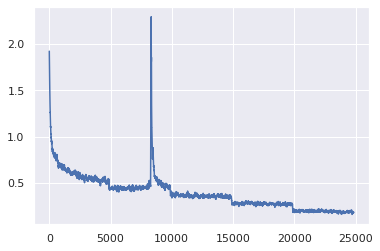

In [ ]:
window_size = 50
smoothed_losses = [] 
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

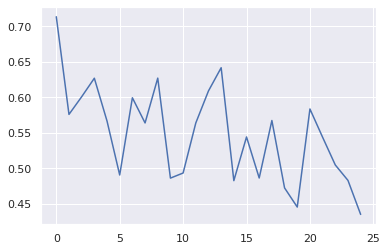

In [ ]:
plt.plot(test_losses[:])

In [ ]:
torch.save(model.state_dict(), model_path_last)

In [ ]:
# tokenizer.save_pretrained('/content/mt5_translation_example_tokenizer')
#!zip -r '/content/mt5_translation_example_tokenizer.zip' '/content/mt5_translation_example_tokenizer'
# !cp '/content/mt5_translation_example_tokenizer.zip' '/content/gdrive/My Drive/mt5_translation_example_tokenizer2.zip'

# Test

In [ ]:
test_sentence = test_dataset[16]['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ru',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)

input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: She called him on the phone. 
Truncated input text: <ru> She called him on the phone. </s><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)

# print(output_tokens)

for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

Она позвонила ему по телефону. 
Она звонила ему по телефону. 
Она позвонила ему по телефону. 


In [ ]:
def translate(text, lang_from, lang_to):
  # test_sentence = test_dataset[16][lang_from]
  # print('Raw input text:', test_sentence)

  input_ids = encode_input_str(
      text = text,
      target_lang = lang_to,
      tokenizer = tokenizer,
      seq_len = model.config.max_length,
      lang_token_map = LANG_TOKEN_MAPPING)

  input_ids = input_ids.unsqueeze(0).cuda()
  # res = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0]))

  output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1)

  res = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

  return res

def translate_to_english(text):
  return translate(text, 'ru', 'en')

def translate_to_russian(text):
  return translate(text, 'en', 'ru')

In [ ]:
translate_to_english('Лондон — столица Великобритании')

'London is the capital of Great Britain. '

In [ ]:
translate_to_russian('When in danger or in doubt, run in circles, scream and shout')

'Когда в опасности или в беде, бегайте в круги, кричите '